## Rental Price Checker based on Gradient Boosting Model

* Objective: to build Rental Price Checker based on Gradient Boosting Model 
* For this question, I would like to use Gradient Boosting Model to asses whether a room rental price is reasonable or not.  
* I hope I would be able to use this for personal use in the future in case I need to move from my current rented room :)
* The original data (>100) was collected randomly based on the actual listing on Carousell, only those listed directly by the owner (not agent) in June 2023 were selected. These raw data were saved inside the file **'sample.carousell.xlsx'**  
* Sample screenshot of the listing is shown below. **13** features were collected (12 categorical and 1 continuous), namely: *Postal Code, Lease, Type, Room, Gender, Air-Con, Cooking, Internet, No Owner Staying, PUB included, Visitors allowed and (Seller's) Asking Price*.  

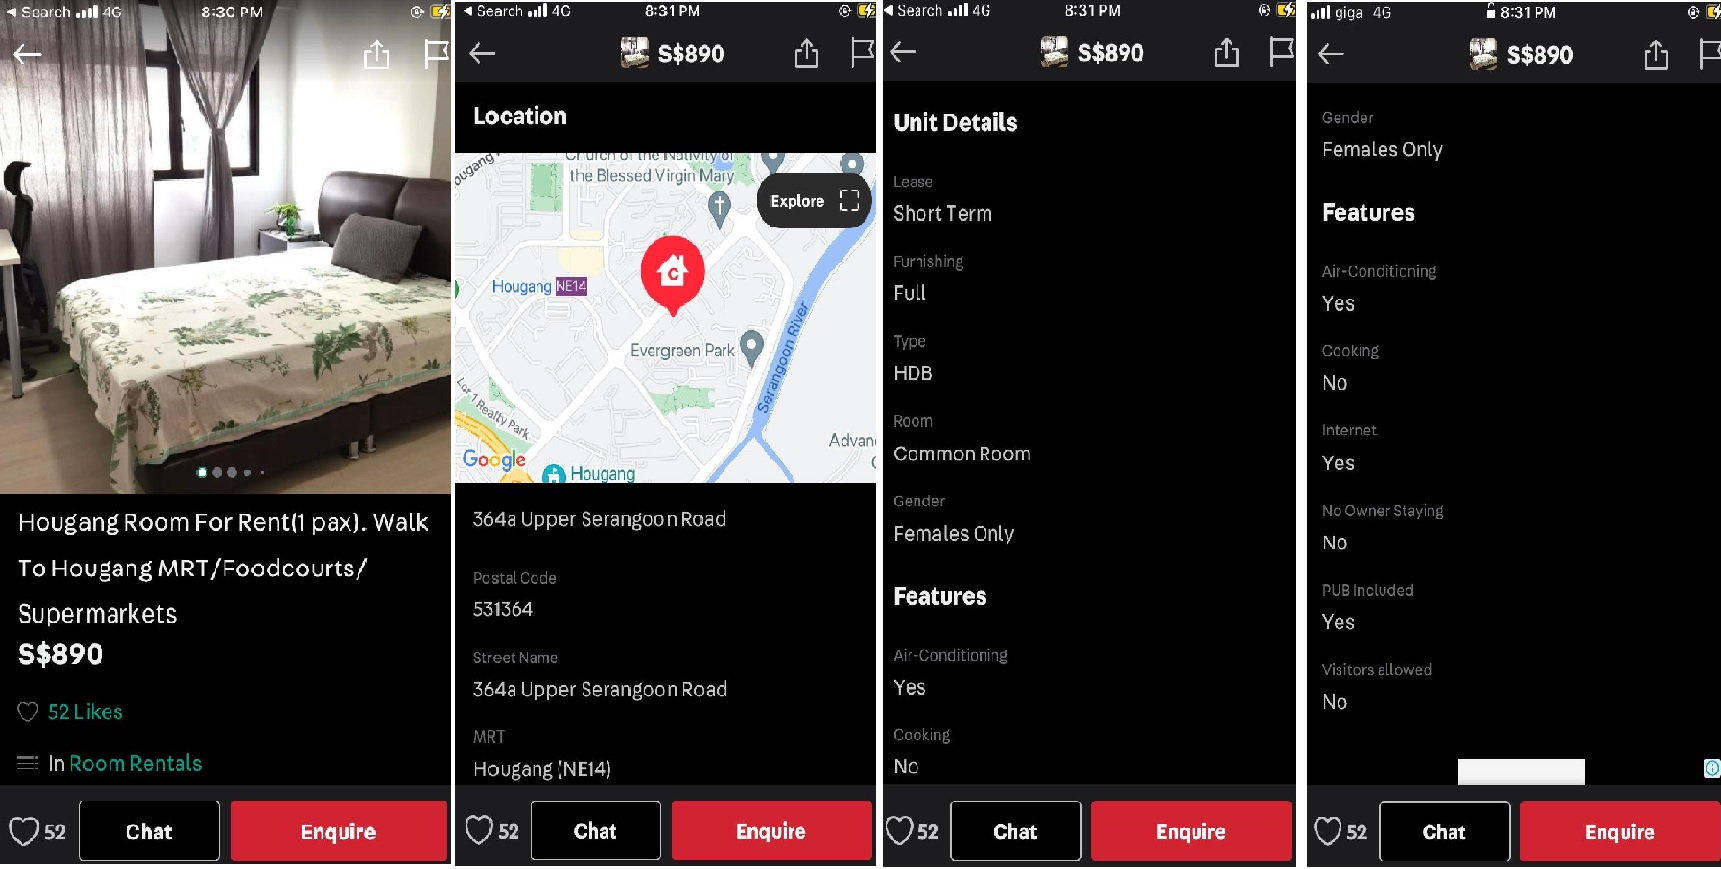

* The raw data prior to processing is shown below, we would convert this data and create an additional *'y'* column before using them in the model

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = 'sample_carousell.xlsx'
df = pd.read_excel(file_path)
df.head()

,Postal Code,Lease,Furnishing,Type,Room,Gender,Air-Con,Cooking,Internet,No Owner Staying,PUB included,Visitors allowed,Asking price
0,440017,Short Term,Full,HDB,Common room,Any Gender,No,No,Yes,No,Yes,No,800
1,530574,1 year,Full,HDB,Common room,Any Gender,No,No,Yes,No,Yes,No,750
2,524230,Flexible,Full,HDB,Master room,Any Gender,Yes,Yes,Yes,No,No,No,1800
3,762430,1 year,Partial,HDB,Common room,Any Gender,No,Yes,Yes,Yes,Yes,No,800
4,460028,1 year,Full,HDB,Common room,Females only,Yes,Yes,Yes,Yes,Yes,No,880


In [4]:
df.dtypes

Postal Code          int64
Lease               object
Furnishing          object
Type                object
Room                object
Gender              object
Air-Con             object
Cooking             object
Internet            object
No Owner Staying    object
PUB included        object
Visitors allowed    object
Asking price         int64
dtype: object

In [5]:
df.shape

(120, 13)

**Preparing the dataset**
* First, we would convert the 'Postal Code' into 'Postal District'. In Singapore, the first two digits of the 'Postal Code' represents the 'Postal District'.  
* Then, the 'Postal Code' column would be relabelled into 'Postal District'

In [6]:
# Define a dictionary mapping postal sectors to postal districts
postal_districts = {
    '01': 1, '02': 1, '03': 1, '04': 1, '05': 1, '06': 1,
    '07': 2, '08': 2,
    '14': 3, '15': 3, '16': 3,
    '09': 4, '10': 4,
    '11': 5, '12': 5, '13': 5,
    '17': 6,
    '18': 7, '19': 7,
    '20': 8, '21': 8,
    '22': 9, '23': 9,
    '24': 10, '25': 10, '26': 10, '27': 10,
    '28': 11, '29': 11, '30': 11,
    '31': 12, '32': 12, '33': 12,
    '34': 13, '35': 13, '36': 13, '37': 13,
    '38': 14, '39': 14, '40': 14, '41': 14,
    '42': 15, '43': 15, '44': 15, '45': 15,
    '46': 16, '47': 16, '48': 16,
    '49': 17, '50': 17, '81': 17,
    '51': 18, '52': 18,
    '53': 19, '54': 19, '55': 19, '82': 19,
    '56': 20, '57': 20,
    '58': 21, '59': 21,
    '60': 22, '61': 22, '62': 22, '63': 22, '64': 22,
    '65': 23, '66': 23, '67': 23, '68': 23,
    '69': 24, '70': 24, '71': 24,
    '72': 25, '73': 25,
    '77': 26, '78': 26,
    '75': 27, '76': 27,
    '79': 28, '80': 28
}

# Extract the first two digits of the postal code and map them to postal districts
df['Postal District'] = df['Postal Code'].astype(str).str[:2].map(postal_districts)

# Insert the 'Postal District' in the first column and drop the 'Postal Code' column
df.insert(1, 'Postal District', df.pop('Postal District'))
df = df.drop('Postal Code', axis=1)

df.head()

,Postal District,Lease,Furnishing,Type,Room,Gender,Air-Con,Cooking,Internet,No Owner Staying,PUB included,Visitors allowed,Asking price
0,15,Short Term,Full,HDB,Common room,Any Gender,No,No,Yes,No,Yes,No,800
1,19,1 year,Full,HDB,Common room,Any Gender,No,No,Yes,No,Yes,No,750
2,18,Flexible,Full,HDB,Master room,Any Gender,Yes,Yes,Yes,No,No,No,1800
3,27,1 year,Partial,HDB,Common room,Any Gender,No,Yes,Yes,Yes,Yes,No,800
4,16,1 year,Full,HDB,Common room,Females only,Yes,Yes,Yes,Yes,Yes,No,880


* Next we would relabel the **12 categorical** feature data in the table according to the following rules:  
    * Postal Zone, divided based on Outside Central Region (0), Rest Central Region (1), Core Central region (2). <p>The Postal district in Singapore represents the different zone with different property price --> central region will have higher price  
    After conversion, the Postal District column would be renamed to Postal Zone
    * Lease: 2 years (0), 1 year (1), short term (2), Flexible (3) --> the more flexible the rental period the higher the price
    * Furnishing: None (0), Partial (1), Full (2) --> furnished property will have higher price
    * Type: HDB (0), Condo (1), Landed property (2) --> landed property normally will have higher price
    * Room: Shared Room (0), Common Room (1), Master Room (2)  --> master room would have a higher price
    * Gender: Any Gender (0), Males only (1), Females only (2) --> exclusive is usually more expensive
    * Air-Con: No (0), Yes (1) --> air-con would have higher price
    * Cooking: No (0), Yes (1) --> cooking would have higher price
    * Internet: No (0), Yes (1) --> internet inclusion would have higher price
    * No Owner Staying: No (0), Yes (1) --> if the owner stay separately, the price is higher
    * PUB included: No (0), Yes(1) --> PUB inclusion would have higher price
    * Visitors allowed: No (0), Yes(1) --> if visitor is allowed, usually the price would be higher

In [7]:
# Select the object columns for label encoding
object_columns = ['Air-Con', 'Cooking', 'Internet', 'No Owner Staying', 'PUB included', 'Visitors allowed']

# Apply label encoding to the selected columns
label_encoder = LabelEncoder()
for column in object_columns:
    df[column] = label_encoder.fit_transform(df[column])
    
le_mapping = {
    'Postal District': {'9':2, '10': 2, '11':2, '1':2, '2':2, '4':2,'6':2,'7':2,
                      '3':1, '5':1,'8':1,'12':1, '13':1, '14':1 ,'15':1, '20':1,
                      '16':0, '17':0,'18':0, '19':0, '21':0,'22':0, '23':0,'24':0, '25':0, '26':0,'27':0,'28':0},
    'Lease': {'2 years': 0, '1 year': 1,  'short term': 2, 'Flexible': 3 },
    'Furnishing': { 'None': 0, 'Partial': 1, 'Full': 2},
    'Type': {'HDB': 0, 'Condo': 1, 'Landed property': 2},
    'Room': {'Shared room': 0, 'Common room': 1, 'Master room': 2 },
    'Gender': {'Any Gender': 0,  'Males only': 1, 'Females only': 2}
}

# Apply label encoding to each feature in the DataFrame
for feature, mapping in le_mapping.items():
    df[feature] = label_encoder.fit_transform(df[feature].map(mapping))

#rename the 'Postal District' to 'Postal Zone'
df = df.rename(columns={'Postal District': 'Postal Zone'})
df.head()

,Postal Zone,Lease,Furnishing,Type,Room,Gender,Air-Con,Cooking,Internet,No Owner Staying,PUB included,Visitors allowed,Asking price
0,0,3,2,0,1,0,0,0,1,0,1,0,800
1,0,1,2,0,1,0,0,0,1,0,1,0,750
2,0,2,2,0,2,0,1,1,1,0,0,0,1800
3,0,1,1,0,1,0,0,1,1,1,1,0,800
4,0,1,2,0,1,2,1,1,1,1,1,0,880


* Next, we would use this new dataset to construct our *y* column 'Is_rent_reasonable'.
* For the calculation, we will leave 'Asking price' feature, the only **continuous feature** in this dataset, as it is.
* The non-trivial deterministic function I came up with is as follows:  

$ \text{temp} = \frac{\text{Asking price}}{1+ \log(1+ \text{Postal Zone} + \text{Lease} + \text{Gender} + \text{Room} + \text{Furnishing} + \text{Type}) + \log(1 + \text{Air-Con} + \text{Cooking} + \text{Internet} + \text{No Owner Staying} + \text{PUB included} + \text{Visitors allowed})} $


$ \text{Is_rent_reasonable} =
\begin{cases}
    0 & \text{if temp} < 251.18 \\
    1 & \text{if temp} \geq 251.18
\end{cases} $
* 251.18 is the median of the calculated temp based on the >100 collected data points
* After the calculation, a new column 'Is_rent_reasonable' is added, we would use this new dataset for our model

In [8]:
# Define the equation for 'Is_rent_reasonable'
def calculate_rent_reasonability(row):
    denominator1 = np.log(1+row['Postal Zone']+row['Lease'] + row['Gender'] + row['Room'] + row['Furnishing'] + row['Type'])
    denominator2 = np.log(1+row['Air-Con'] + row['Cooking'] + row['Internet'] + row['No Owner Staying'] + row['PUB included'] + row['Visitors allowed'])
    result = (1 / (1+denominator1 + denominator2)) * row['Asking price'] 
    return result

# Apply the custom function to create the 'Is_rent_reasonable' column which would be our y value
df['Is_rent_reasonable'] = df.apply(calculate_rent_reasonability, axis=1)

# Calculate the median of 'Is_rent_reasonable'
median = df['Is_rent_reasonable'].median()

# Replace values based on median (0 - unreasonable rent, 1-reasonable rent)
df['Is_rent_reasonable'] = np.where(df['Is_rent_reasonable'] > median, 0,1)

df

,Postal Zone,Lease,Furnishing,Type,Room,Gender,Air-Con,Cooking,Internet,No Owner Staying,PUB included,Visitors allowed,Asking price,Is_rent_reasonable
0,0,3,2,0,1,0,0,0,1,0,1,0,800,1
1,0,1,2,0,1,0,0,0,1,0,1,0,750,1
2,0,2,2,0,2,0,1,1,1,0,0,0,1800,0
3,0,1,1,0,1,0,0,1,1,1,1,0,800,1
4,0,1,2,0,1,2,1,1,1,1,1,0,880,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,2,1,0,1,0,1,1,1,0,1,0,2500,0
116,0,1,2,0,1,0,1,0,1,1,1,0,950,1
117,0,1,2,0,1,0,1,1,1,1,1,1,1400,0
118,0,2,1,0,1,1,0,0,1,0,1,0,1000,0


**(Q2.4) The dataset is ready**  
* Our dataset is now ready, we would create a copy of the dataset and use this copy for our modelling 

In [9]:
df2=df.copy()
df2.head()

,Postal Zone,Lease,Furnishing,Type,Room,Gender,Air-Con,Cooking,Internet,No Owner Staying,PUB included,Visitors allowed,Asking price,Is_rent_reasonable
0,0,3,2,0,1,0,0,0,1,0,1,0,800,1
1,0,1,2,0,1,0,0,0,1,0,1,0,750,1
2,0,2,2,0,2,0,1,1,1,0,0,0,1800,0
3,0,1,1,0,1,0,0,1,1,1,1,0,800,1
4,0,1,2,0,1,2,1,1,1,1,1,0,880,1


* We would train our normalized dataset using GradientBoostingClasifier

In [10]:
# Split the dataset into input features (X) and the target variable (y)
X = df2.drop('Is_rent_reasonable', axis=1)
y = df2['Is_rent_reasonable']

# Split the data into training and testing sets
# the random_state value was chosen based on trial and error(for loop for random_state-not shown)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=252)

# Create an instance of GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=252)

# Fit the model on the training data
clf.fit(X_train, y_train)    

GradientBoostingClassifier(random_state=252)

* The accuracy of the model is shown below

In [11]:
print("accuracy for training dataset", accuracy_score(y_train, clf.predict(X_train)))
print("accuracy for test dataset", accuracy_score(y_test, clf.predict(X_test)))

accuracy for training dataset 1.0
accuracy for test dataset 1.0


In [12]:
y_test.value_counts()

0    21
1    15
Name: Is_rent_reasonable, dtype: int64

In [13]:
print(confusion_matrix(y_test, clf.predict(X_test)))

[[21  0]
 [ 0 15]]


In [14]:
print(classification_report(y_test, clf.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        21
           1      1.000     1.000     1.000        15

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36



In [15]:
# percentage of wrongly classified test data points
np.mean(clf.predict(X_test) != y_test) 

0.0

* GridSearchCV is used to tune the hyperparameters

In [16]:
# use GridSearchCV to automate the hyperparameter tuning processs
# Define the parameter grid
param_grid = {
    'learning_rate': [1.5, 1, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'criterion':['friedman_mse', 'squared_error']
}

# Create the GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=252)

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}


In [17]:
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
accuracy = best_model.score(X_test, y_test)
print("Accuracy on test data: ", accuracy)

Accuracy on test data:  1.0


* Testing the model with new hyperparameters

In [18]:
# Create an instance of GradientBoostingClassifier with desired hyperparameters
clf2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, n_estimators=300, criterion= 'friedman_mse', random_state=252)

# Fit the model on the training data
clf2.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=300, random_state=252)

In [19]:
print("new accuracy for training dataset", accuracy_score(y_train, clf2.predict(X_train)))
print("new accuracy for test dataset", accuracy_score(y_test, clf2.predict(X_test)))

new accuracy for training dataset 1.0
new accuracy for test dataset 1.0


* Making prediction for new data
* [A simplified user interface is shown in this part](#section-b)

In [35]:
#test with new data
new_data = np.array([[0,0,2,1,0,0,0,1,1,1,1,0,800]])

if clf2.predict(new_data)[0] == 1:
    print ("For the inputted data, the predicted class is 1 (i.e. Yes it is a good price)")
else:
    print ("For the inputted data, the predicted class is 0 (i.e. No it is not a reasonable price)")   

print (",and probability of belonging to class 1 is", 
       np.round(clf2.predict_proba(new_data)[0][1], 2))


For the inputted data, the predicted class is 1 (i.e. Yes it is a good price)
,and probability of belonging to class 1 is 1.0


<a id="section-b"></a>
<h2 style="font-size: large;">Simplified Interface for the User for Q2</h2>  

* Additional simplified interface, the user would be able to enter the actual postal code input from Carousell.
<h2 style="font-size: small;"><em>(Sorry, not enough time to debug yet, but it works if we put the correct input (no string etc))</em></h2>

In [37]:
new_data2 = []

postal_code_input = str(input("Enter Postal Code (max 6 digits, e.g.532182): "))
postal_district = postal_districts.get(postal_code_input[:2])
postal_region = {'9':2, '10': 2, '11':2, '1':2, '2':2, '4':2,'6':2,'7':2,
                 '3':1, '5':1,'8':1,'12':1, '13':1, '14':1 ,'15':1, '20':1,
                 '16':0, '17':0,'18':0, '19':0, '21':0,'22':0, '23':0,'24':0, '25':0, '26':0,'27':0,'28':0}
new_data2.append(postal_region[str(postal_district)])

lease = int(input("Enter Lease - 2 years(0), 1 year(1), short term(2), Flexible(3): "))
new_data2.append(lease)

furnishing = int(input("Enter Furnishing - None(0), Partial(1), Full(2): "))
new_data2.append(furnishing)

type_value = int(input("Enter Type - HDB(0), Condo(1), Landed property(2): "))
new_data2.append(type_value)

room = int(input("Enter Room - Shared Room(0), Common Room(1), Master Room(2): "))
new_data2.append(room)

gender = int(input("Enter Gender - Any Gender(0), Males only(1), Females only(2): "))
new_data2.append(gender)

air_con = int(input("Enter Air-Con-No(0), Yes(1): "))
new_data2.append(air_con)

cooking = int(input("Enter Cooking-No(0), Yes(1): "))
new_data2.append(cooking)

internet = int(input("Enter Internet-No(0), Yes(1): "))
new_data2.append(internet)

owner_staying = int(input("Enter No Owner Staying-No(0), Yes(1): "))
new_data2.append(owner_staying)

pub_included = int(input("Enter PUB included-No(0), Yes(1): "))
new_data2.append(pub_included)

visitors_allowed = int(input("Enter Visitors allowed-No(0), Yes(1): "))
new_data2.append(visitors_allowed)

asking_price = int(input("Enter Seller's Asking price (SGD): "))
new_data2.append(asking_price)

#test with new data
new_data = np.array([new_data2])

if clf2.predict(new_data)[0] == 1:
    print ("\nFor the inputted data, the predicted class is 1 (i.e. Yes it is a good price)")

else:
    print ("\nFor the inputted data, the predicted class is 0 (i.e. No it is not a reasonable price)")
    
print ("The probability of belonging to class 1 is", 
       np.round(clf2.predict_proba(new_data)[0][1], 2))

Enter Postal Code (max 6 digits, e.g.532182): 399221
Enter Lease - 2 years(0), 1 year(1), short term(2), Flexible(3): 0
Enter Furnishing - None(0), Partial(1), Full(2): 0
Enter Type - HDB(0), Condo(1), Landed property(2): 0
Enter Room - Shared Room(0), Common Room(1), Master Room(2): 0
Enter Gender - Any Gender(0), Males only(1), Females only(2): 0
Enter Air-Con-No(0), Yes(1): 1
Enter Cooking-No(0), Yes(1): 1
Enter Internet-No(0), Yes(1): 1
Enter No Owner Staying-No(0), Yes(1): 1
Enter PUB included-No(0), Yes(1): 1
Enter Visitors allowed-No(0), Yes(1): 1
Enter Seller's Asking price (SGD): 1

For the inputted data, the predicted class is 1 (i.e. Yes it is a good price)
The probability of belonging to class 1 is 1.0


In [38]:
import joblib
joblib.dump(clf2, 'model_clf.pkl')

['model_clf.pkl']